# Import packages

In [103]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [104]:
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 

import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

import statsmodels.api as sm
from sklearn.metrics import log_loss
# Plotting tools
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os

Populating the interactive namespace from numpy and matplotlib


In [105]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [106]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(graphics)

In [244]:
def dual_corr(title,x_variable,y_variable,x_varlabel,y_varlabel,data_exp1,data_exp2):
    
    f = plt.figure(figsize=(10,10))
    sns.set(style='white', font_scale=1.8)

    #First dataset (green)
    ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#33CC00', scatter_kws={'s':70,'alpha':0.3},x_jitter=.1)
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    
    x=data_exp1[x_variable].values
    y=data_exp1[y_variable].values
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='green', lw=3)
    
    results = pearsonr(y,x)
    print ("Pearson's  Green r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    
    
    
    #Second dataset (blue)
    ax = sns.regplot(data=data_exp2, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#0057DE', scatter_kws={'s':70,'alpha':0.3},x_jitter=.1)
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    
    x=data_exp2[x_variable]
    y=data_exp2[y_variable]
    fit = np.polyfit(x, y, deg=2)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='blue', lw=3)
    
    results = pearsonr(y,x)
    print ("Pearson's  Blue r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

    
    sns.despine()
    ax.set_title(title) 

In [ ]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

## Load data

In [107]:
data_glam = pd.read_csv('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv')
# Load data for FF2018 study 
data_all = pd.read_csv('data/FF2018_data/FFAllData_Like.csv')
# Load fixation sequence
data_fix = pd.read_csv('data/FF2018_data/fixations_seq_Like.csv')

In [108]:
#drop columns and value from bins
data_glam = data_glam.drop(['Unnamed: 0'], axis=1)
data_glam = data_glam.drop(['item_value_0'], axis=1)
data_glam = data_glam.drop(['item_value_1'], axis=1)

#drop columns and value from bins
data_glam['item_value_0'] = data_all.LVal
data_glam['item_value_1'] = data_all.RVal
data_glam['correct'] = data_all.Correct

## Correct / Incorrect and RT
------------------------------------------
How to model the accumulation of evidence?
Do we observe from the data that RT is dependent on the difference in relative evidence? In this case DV should present an effect over the proportion of correct and incorrect. Is it dependant on the Value of the options (high value --> high evidence)? In this case we should answer better when the value of items is higher.

In [109]:
Correct_trials = data_all.loc[data_all['Correct'] == 1]
Incorrect_trials = data_all.loc[data_all['Correct'] == 0]

Delta_RT = Correct_trials.RT.mean() - Incorrect_trials.RT.mean()


-413.6043595103015

mean(RT|Correct) - mean(RT|Incorrect) =  -413.6043595103015 ; p-value =3.916568072262644e-09


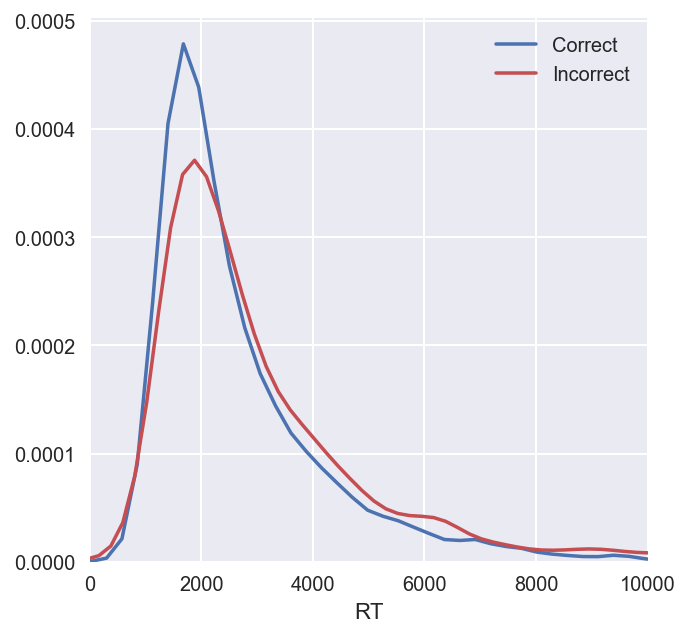

In [111]:
ax1 = sns.distplot(Correct_trials.RT, bins=30, rug=False, hist = False, color = 'b',label = 'Correct');
ax2 = sns.distplot(Incorrect_trials.RT, bins=30, rug=False, hist = False, color = 'r',label = 'Incorrect');
plt.xlim(0, 10000)


diff = Correct_trials.RT.mean() - Incorrect_trials.RT.mean()
[s, p] = stats.ttest_ind(Correct_trials.RT,Incorrect_trials.RT)
print ("mean(RT|Correct) - mean(RT|Incorrect) =  " + str(diff) + " ; p-value =" + str(p) )
#plt.plot([mean_rts], [0.00005 + 0.00005*trial], marker='o', markersize=5, color="red")
#plt.text(mean_rts,0.00005 + 0.00005*trial, str(value_trial))


Pearson's  Green r = -0.086 p =  0.0
Pearson's  Blue r = 0.018 p =  0.573


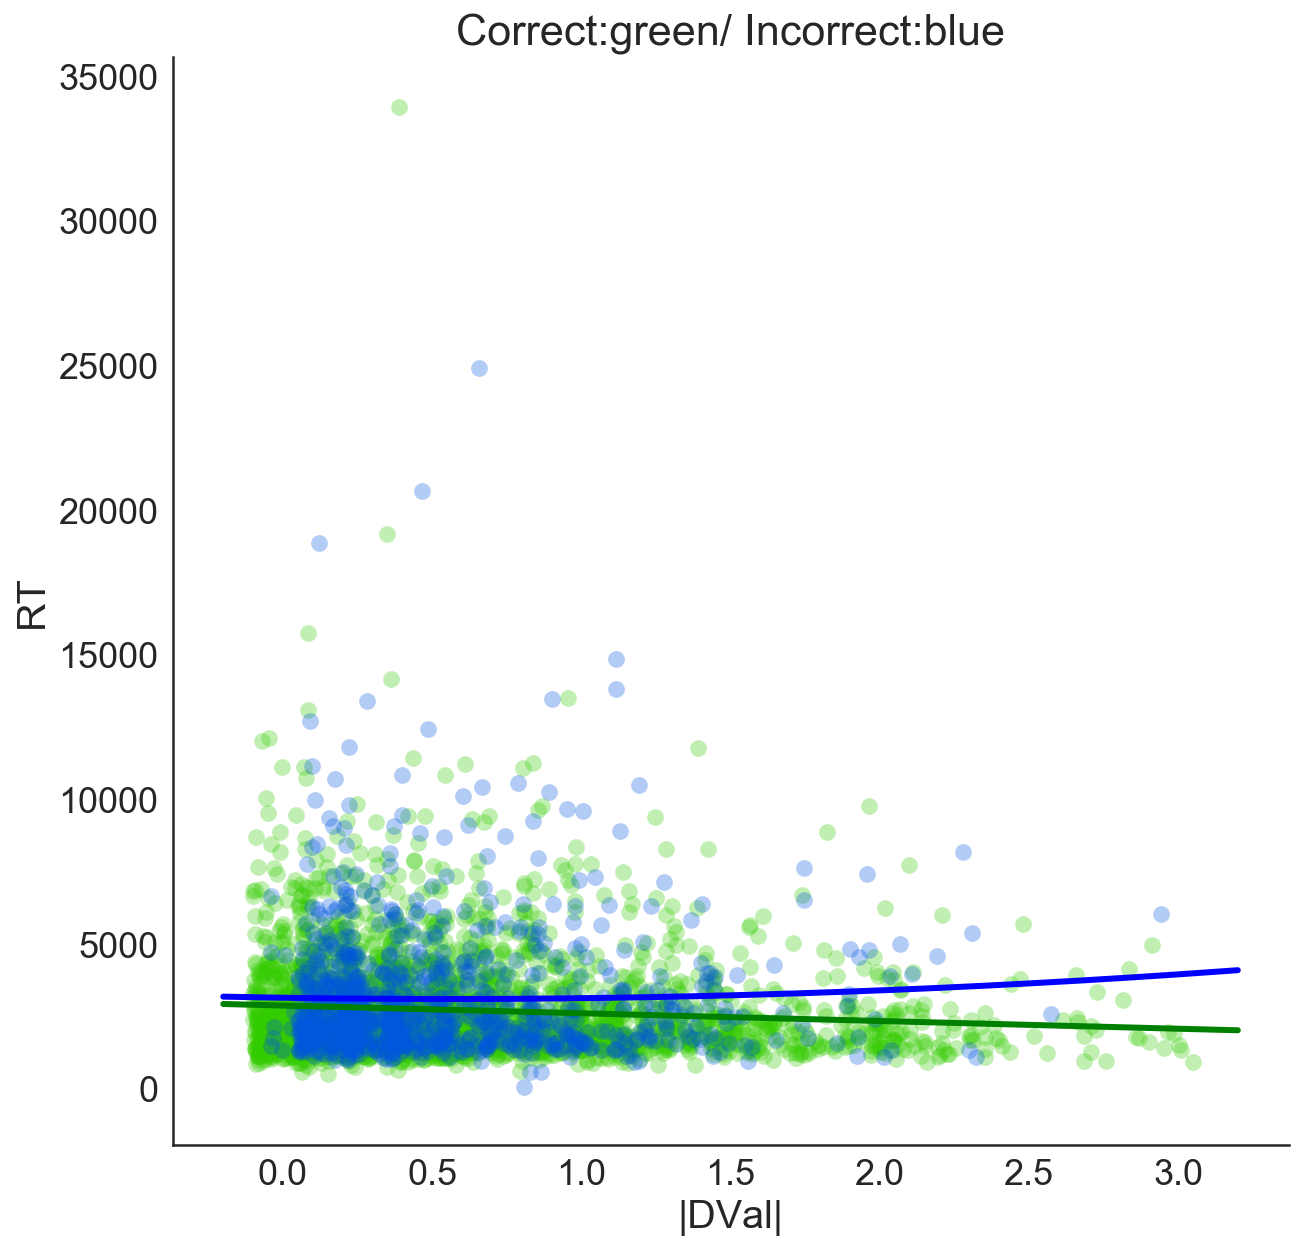

In [245]:

#dual_corr(x_variable,y_variable,x_varlabel,y_varlabel,data_exp1,data_exp2)
dual_corr("Correct:green/ Incorrect:blue",'AbsDVal','RT','|DVal|','RT',Correct_trials,Incorrect_trials)

In [208]:
%%R -i data_all
datas  <- data_all

BIC: 4387.669
Call:  glm(formula = Correct ~ zRT + zAbsDVal + TotVal, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)          zRT     zAbsDVal       TotVal  
     1.5843      -0.1866       0.1389      -0.2283  

Degrees of Freedom: 3959 Total (i.e. Null);  3956 Residual
Null Deviance:	    4443 
Residual Deviance: 4355 	AIC: 4363


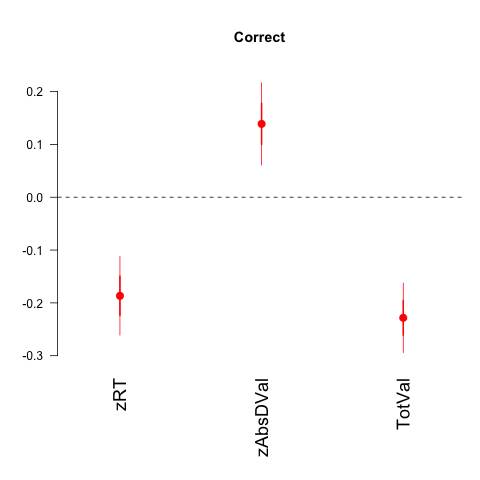

In [209]:
%%R
title_plot = " Correct  "
ModelCorrect_1 <- glm(Correct ~ zRT + zAbsDVal +TotVal , data= datas, family=binomial(link="logit"))
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

BIC: 10655.26
Call:  glm(formula = zRT ~ Correct + zAbsDVal + zAbsDVal:Correct, data = datas)

Coefficients:
     (Intercept)           Correct          zAbsDVal  Correct:zAbsDVal  
         0.05453          -0.19281          -0.05937          -0.07632  

Degrees of Freedom: 3959 Total (i.e. Null);  3956 Residual
Null Deviance:	    3474 
Residual Deviance: 3383 	AIC: 10620


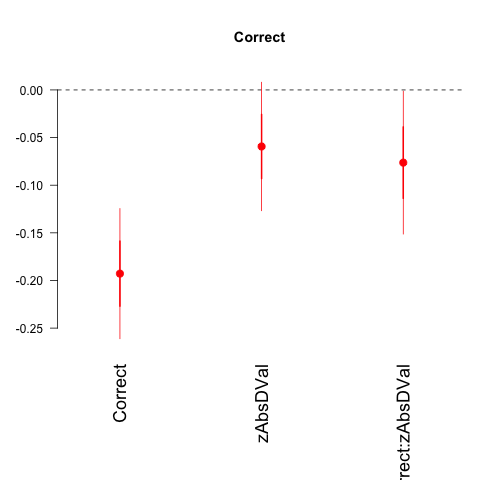

In [211]:
%%R
title_plot = " Correct  "
ModelCorrect_1 <- glm(zRT ~ Correct + zAbsDVal +zAbsDVal:Correct , data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

----------------------------------------------------------------------------------
# Regressions for Choice (alternative models)

## 1. Optimize only using DV

In [252]:
data_glam["zDVal"] = data_all['zDVal']

In [265]:
z_matrix=[]
z_matrix_aux=[]
likelihood_all = []
slope_all = []
bic_all = []

free_params = 1

## We have to calculate for various gamma values and obtain the maximum likelihood

for i in (data_glam['subject'].unique()):
    Choicedata = data_glam.loc[data_glam['subject'] == i]
    # Find out the gamma with the higher likelihood
    
    best_gamma_model = []
    # Calculate difference in R value (right minus left)
    
    DV= Choicedata.item_value_1 - Choicedata.item_value_0
    # Using linear model available in run_linear_model(x, y, verbose=True):
    logit = sm.Logit(Choicedata['choice'], Choicedata['zDVal'])    
    #logit = sm.Logit(Choicedata['choice'], DV)    
    result = logit.fit(disp=0)
    ## llf allows to obtain log-likelihood

    likelihood_all.append(result.llf)
    slope_all.append(result.params)
    bic_all.append(np.log(len(Choicedata))*free_params - 2*result.llf)

    z_matrix_aux= np.column_stack(([result.params.values[0]]*len(Choicedata),DV))
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])
        
aggregate_trial = np.column_stack((data_glam,z_matrix))
data_glam2_DV = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","gaze_0","gaze_1","item_value_0","item_value_1","correct","zDVal","slope_logit", "DV"])
     

indiv_DV_BIC = bic_all
# BIC= ln(n)*k - 2ln(L)  
DV_BIC = np.log(len(Choicedata)*len(data_glam2_DV['subject'].unique()))*free_params - 2*sum(likelihood_all)
indiv_DV_BIC = sum(bic_all)

print(DV_BIC) 

4243.9131833051015


In [256]:
data_glam2_DV.head()

,subject,trial,rt,choice,gaze_0,gaze_1,item_value_0,item_value_1,correct,zDVal,slope_logit,DV
0,0.0,0.0,2009.0,0.0,0.568396,0.431604,1.10,0.95,1.0,-0.242061,2.583583,2.85
1,0.0,1.0,3371.0,0.0,0.762332,0.237668,2.00,1.70,1.0,-0.484123,2.583583,-0.45
2,0.0,2.0,1700.0,1.0,0.446809,0.553191,1.10,2.30,1.0,1.936492,2.583583,-0.15
3,0.0,3.0,7466.0,1.0,0.532352,0.467648,1.25,1.40,1.0,0.242061,2.583583,-0.15
4,0.0,4.0,1889.0,1.0,0.529736,0.470264,2.00,2.30,1.0,0.484123,2.583583,-0.60


## 2. Calculate optimization to predict choice using linear transformation for values 

In [145]:

z_matrix=[]
z_matrix_aux=[]
likelihood_all_opti2 = []
slope_all_opti2 = []
gamma_all_opti2 = []
bic_all_opti2=[]
free_params = 2


## We have to calculate for various gamma values and obtain the maximum likelihood

for i in (data_glam['subject'].unique()):
    Choicedata = data_glam.loc[data_glam['subject'] == i]
    # Find out the gamma with the higher likelihood
    
    best_gamma = -1
    best_gamma_logLik = float("-inf")
    #best_gamma_model = []
    
    likelihood_plot = []
    for gamma in frange(0,1,0.05):

        abs_evid_0 = Choicedata.gaze_0 * Choicedata.item_value_0 + (1-Choicedata.gaze_0) * Choicedata.item_value_0*gamma
        abs_evid_1 = Choicedata.gaze_1 * Choicedata.item_value_1 + (1-Choicedata.gaze_1) * Choicedata.item_value_1*gamma
        R0_star= abs_evid_0 - abs_evid_1
        R1_star= abs_evid_1 - abs_evid_0
        
        # Calculate Relative evidence using Marius trnasformation
        R0=(R0_star-R0_star.min())/(R0_star.max()-R0_star.min())
        R1=(R1_star-R1_star.min())/(R1_star.max()-R1_star.min())
        
        # Calculate difference in R value (right minus left)
        DR= R1 - R0
        
        # Using linear model available in run_linear_model(x, y, verbose=True):

        logit = (Choicedata['choice'], DR)

        result = logit.fit(disp=0)
        
        ## llf allows to obtain log-likelihood
        likelihood_curr = result.llf
        likelihood_plot.append(likelihood_curr)
        
        slope_curr = result.params.values[0]
        
        if likelihood_curr > best_gamma_logLik:
            best_gamma_logLik = likelihood_curr
            best_gamma_model = result
            best_gamma= gamma
            Best_gamma_DR =  DR
            Best_gamma_R0 =  R0
            Best_gamma_R1 =  R1
            Best_gamma_slope = slope_curr

        
 #   ## plot likelihood through gammas
 #   fig = plt.figure()
 #   ax = plt.axes()
 #   x = frange(0,1,0.05)
 #   ax.plot(x,likelihood_plot);
 #   ax.set(
 #      xlabel='gamma', ylabel='log-likelihood',
 #      title='particpant '+str(i));
    #---------------------------------
    
 #  print (best_gamma_model.summary())
    likelihood_all_opti2.append(best_gamma_logLik)
    gamma_all_opti2.append(best_gamma)
    slope_all_opti2.append(Best_gamma_slope)
    bic_all_opti2.append(np.log(len(Choicedata))*free_params - 2*best_gamma_logLik)



    z_matrix_aux= np.column_stack(([best_gamma]*len(Choicedata),Best_gamma_DR,Best_gamma_R0,Best_gamma_R1))
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])
        
aggregate_trial = np.column_stack((data_glam,z_matrix))
data_glam2_linTrans = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","gaze_0","gaze_1","item_value_0","item_value_1","correct","gamma","DR","R0","R1"])

# BIC= ln(n)*k - 2ln(L)  

free_params = 2
             
indiv_best_gamma_BIC = sum(bic_all_opti2)                
best_gamma_BIC = np.log(len(Choicedata)*len(data_glam2_linTrans['subject'].unique()))*free_params - 2*sum(likelihood_all_opti2)
print(best_gamma_BIC)
      

3570.170686598477


In [146]:
gamma_all_opti2

[0.05,
 0.65,
 0.30000000000000004,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.45,
 0.0,
 0.0,
 0.0,
 0.65,
 0.65,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8500000000000001,
 0.35000000000000003,
 0.0,
 0.0,
 0.45,
 0.0,
 0.0,
 0.0,
 1.0,
 0.05]

## 3. Calculate optimization to predict choice using GLAM transformation of values

In [147]:
z_matrix=[]
z_matrix_aux=[]
likelihood_all_opti3 = []
slope_all_opti3 = []
DR_all = []
gamma_all_opti3 = []
tau_all_opti3 = []
bic_all_opti3 = []


free_params = 3


## We have to calculate for various gamma values and obtain the maximum likelihood

for i in (data_glam['subject'].unique()):
    Choicedata = data_glam.loc[data_glam['subject'] == i]
    # Find out the gamma with the higher likelihood
    
    best_gamma = -1
    best_gamma_logLik = float("-inf")
    #best_gamma_model = []
    
    for gamma in frange(0,1,0.05):

        for tau in frange(0.1,10,0.5):

            abs_evid_0 = Choicedata.gaze_0 * Choicedata.item_value_0 + (1-Choicedata.gaze_0) * Choicedata.item_value_0*gamma
            abs_evid_1 = Choicedata.gaze_1 * Choicedata.item_value_1 + (1-Choicedata.gaze_1) * Choicedata.item_value_1*gamma
            R0_star= abs_evid_0 - abs_evid_1
            R1_star= abs_evid_1 - abs_evid_0

            # Calculate Relative evidence using Marius trnasformation
            R0= 1/(1+exp(-R0_star*tau))
            R1= 1/(1+exp(-R1_star*tau))

            # Calculate difference in R value (right minus left)
            DR= R1 - R0

            # Using linear model available in run_linear_model(x, y, verbose=True):

            logit = sm.Logit(Choicedata['choice'], DR)

            result = logit.fit(disp=0)

            ## llf allows to obtain log-likelihood
            likelihood_curr = result.llf
            slope_curr = result.params.values[0]


            if likelihood_curr > best_gamma_logLik:
                best_gamma_logLik = likelihood_curr
                best_gamma_model = result
                best_gamma = gamma
                best_tau = tau
                Best_gamma_DR =  DR
                Best_gamma_R0 =  R0
                Best_gamma_R1 =  R1
                Best_gamma_slope = slope_curr


            #-----------------------------
    
    
    likelihood_all_opti3.append(best_gamma_logLik)
    gamma_all_opti3.append(best_gamma)
    tau_all_opti3.append(best_tau)
    slope_all_opti3.append(Best_gamma_slope)
    bic_all_opti3.append(np.log(len(Choicedata))*free_params - 2*best_gamma_logLik)

    
    z_matrix_aux= np.column_stack(([best_gamma]*len(Choicedata),[best_tau]*len(Choicedata),Best_gamma_DR,Best_gamma_R0,Best_gamma_R1))
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])
        
aggregate_trial = np.column_stack((data_glam,z_matrix))
data_glam2_logTransf = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","gaze_0","gaze_1","item_value_0","item_value_1","correct","gamma","tau","DR","R0","R1"])

# BIC= ln(n)*k - 2ln(L)  

In [148]:
free_params = 3
indiv_best_gamma_tau_BIC = sum(bic_all_opti3)                
best_gamma_tau_BIC = np.log(len(Choicedata)*len(data_glam2_logTransf['subject'].unique()))*free_params - 2*sum(likelihood_all_opti3)
print(best_gamma_tau_BIC)
      

3431.5093999803216


In [149]:
best_gamma_tau_BIC

3431.5093999803216

([<matplotlib.axis.XTick at 0x1c22492748>,
 <a list of 3 Text xticklabel objects>)

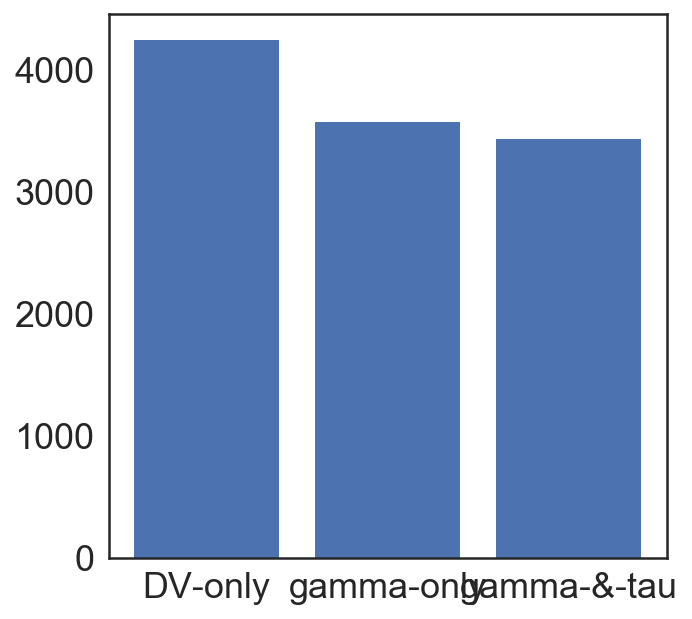

In [266]:
BICs = [DV_BIC,best_gamma_BIC,best_gamma_tau_BIC]
plt.bar(range(len(BICs)),BICs, align='center')
plt.xticks(range(len(BICs)), ['DV-only','gamma-only','gamma-&-tau'])

## Adding individual BICs

([<matplotlib.axis.XTick at 0x1c23036b00>,
 <a list of 3 Text xticklabel objects>)

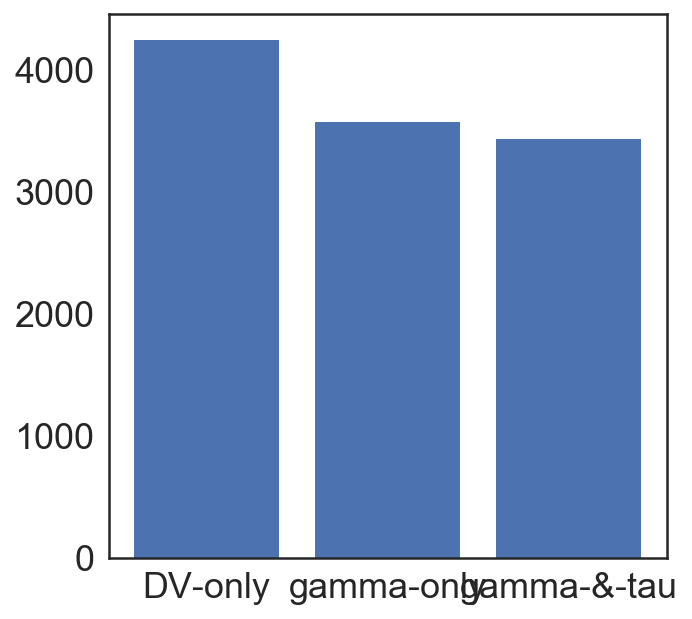

In [267]:
indiv_BICs =  [indiv_DV_BIC,indiv_best_gamma_BIC,indiv_best_gamma_tau_BIC]
plt.bar(range(len(BICs)),BICs, align='center')
plt.xticks(range(len(BICs)), ['DV-only','gamma-only','gamma-&-tau'])

In [124]:
bics_indiv = np.column_stack(([indiv_DV_BIC,indiv_best_gamma_BIC,indiv_best_gamma_tau_BIC]))

bics_indiv = pd.DataFrame(bics_indiv,columns=["DV","gamma","gamma-tau"])


In [125]:
bics_indiv.mean()

DV           4394.310140
gamma        3621.975324
gamma-tau    3491.107286
dtype: float64

In [24]:
# Even if we take the individual BIC values average, still we keep the trend.

In [ ]:
# Are we calculating them properly?? Check if individual BIC are different from the total 

#DV_BIC = np.log(len(Choicedata)*len(data_glam2_DV['subject'].unique()))*free_params - 2*sum(likelihood_all)
## FOR DV
detrans = [(np.log(120)*1 - x)/2 for x in indiv_DV_BIC]
DV_BIC2 = np.log(120*33)*1 - 2*sum(detrans)
DV_BIC2

# FOR BEST-GAMMA
detrans = [(np.log(120)*2 - x)/2 for x in indiv_best_gamma_BIC]
gamma_BIC2 = np.log(120*33)*2 - 2*sum(detrans)
gamma_BIC2

# FOR BEST-GAMMA-and-Tau
detrans = [(np.log(120)*3 - x)/2 for x in indiv_best_gamma_tau_BIC]
gamma_tau_BIC2 = np.log(120*33)*3 - 2*sum(detrans)
gamma_tau_BIC2

# YES, I'm obtaining the same results 

## extracting info from the best optimization (the one with logarithmic transformation)

In [126]:
data_test = pd.DataFrame({'correct':data_glam2_logTransf['correct'],'choice':data_glam2_logTransf['choice'],'DR':data_glam2_logTransf['DR'],'DVal': data_all['DVal']
                          ,'AbsDR':abs(data_glam2_logTransf['DR']),'AbsDVal': abs(data_all['DVal'])})

In [127]:
%%R -i data_test
datas  <- data_test

BIC: 4444.553
Call:  glm(formula = correct ~ AbsDVal, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)      AbsDVal  
     0.9539       0.2700  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    4443 
Residual Deviance: 4428 	AIC: 4432


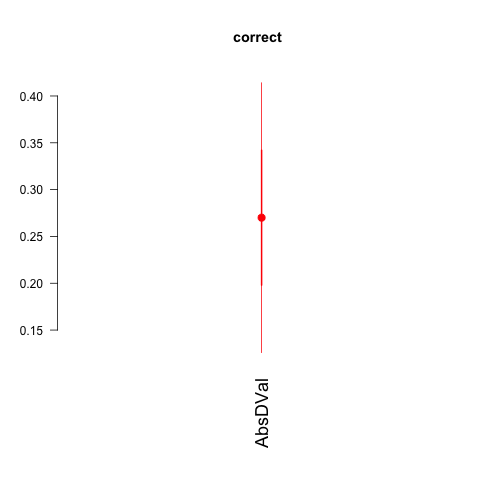

In [128]:
%%R    
title_plot = "correct  "
ModelChoice_1 <- glm(correct ~ AbsDVal  , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1 = BIC(ModelChoice_1)
cat("BIC:" , BIC1)
ModelChoice_1

BIC: 4432.676
Call:  glm(formula = correct ~ AbsDR, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)        AbsDR  
     0.8811       0.4779  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    4443 
Residual Deviance: 4416 	AIC: 4420


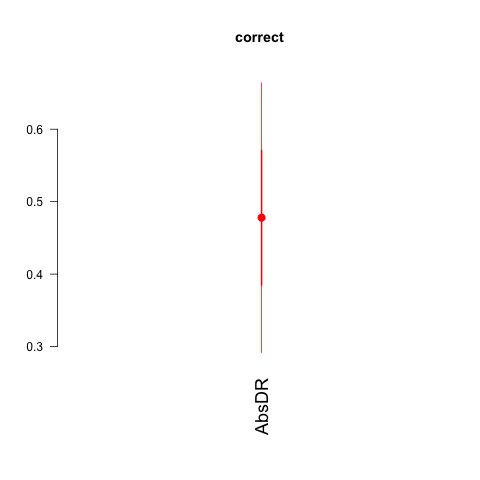

In [129]:
%%R    
title_plot = " correct  "
ModelChoice_1 <- glm(correct ~ AbsDR  , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1 = BIC(ModelChoice_1)
cat("BIC:" , BIC1)
ModelChoice_1

BIC: 4777.82
Call:  glm(formula = choice ~ DVal, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)         DVal  
   0.007304     1.312929  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    5490 
Residual Deviance: 4761 	AIC: 4765


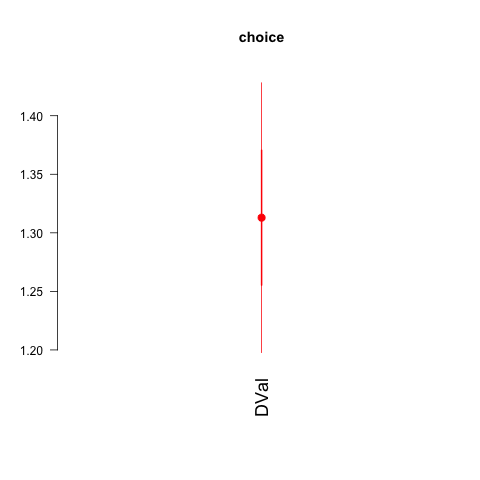

In [61]:
%%R    
title_plot = "choice"
ModelChoice_1 <- glm(choice ~ DVal  , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1 = BIC(ModelChoice_1)
cat("BIC:" , BIC1)
ModelChoice_1

BIC: 3831.279
Call:  glm(formula = choice ~ DR, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)           DR  
   0.007475     2.745012  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    5490 
Residual Deviance: 3815 	AIC: 3819


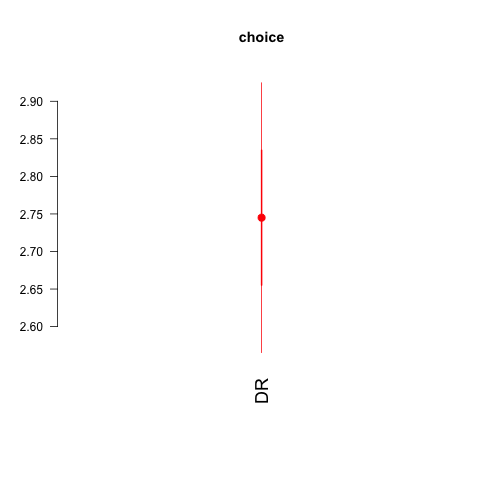

In [62]:
%%R    
title_plot = "choice"
ModelChoice_1 <- glm(choice ~ DR  , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1 = BIC(ModelChoice_1)
cat("BIC:" , BIC1)
ModelChoice_1

------------------------------------------------
# Accumulator models 

## For accumulators we fit the parameters : attentional ($\gamma$) and decay ($\lambda$)

In [81]:
## Load fixation sequence


In [82]:
data_fix.head()

,parcode,trial,fix_item,fix_time
0,0,0,3,313
1,0,0,1,258
2,0,0,1,294
3,0,0,2,342
4,0,0,2,286


In [83]:
# We wont consider accumulation of evidence in the case the participant doesn't observe the IA

In [84]:
IAFixMatrix = []

for i in (data_fix['parcode'].unique()):
    PartIAFixMatrix= data_fix.loc[(data_fix['parcode'] == i )]
    trialNums = pd.unique(PartIAFixMatrix["trial"])
    for j in trialNums:
        
        PartTrialIAFixMatrix= PartIAFixMatrix.loc[(PartIAFixMatrix['trial'] == j )]
        # considering that IA 1 is left and IA 2 is right ( IAs 3 and 0 are not fixated in the item)
        # I won't consider time in this case
        FixSequence = PartTrialIAFixMatrix.loc[(PartTrialIAFixMatrix['fix_item'] != 0) & (PartTrialIAFixMatrix['fix_item'] != 3), 'fix_item']
        FixSequence = FixSequence.values
        #LGazeTime = PartTrialIAFixMatrix.loc[PartTrialIAFixMatrix['fix_item'] == 1, 'fix_time'].sum() 
        ## Sum right item
        #RGazeTime = PartTrialIAFixMatrix.loc[PartTrialIAFixMatrix['fix_item'] == 2, 'fix_time'].sum()  
        #LGaze = LGazeTime/(LGazeTime + RGazeTime)
        #RGaze = RGazeTime/(LGazeTime + RGazeTime)
        
        IAFixMatrix.append(FixSequence) 

In [85]:
# Add to aggregate dataframe
aggregate_trial_2 = np.column_stack((data_glam,IAFixMatrix))
data_accumula = pd.DataFrame(aggregate_trial_2,columns=["subject","trial","rt","choice","gaze_0","gaze_1","item_value_0","item_value_1","correct","fix_seq"])

## $\gamma$ free paramters only (model 1)

In [ ]:
# initialize accumulators vectors. We will generate an accumulator vector for right and left options
# for each trial
x_L_seq = []
x_R_seq = []
x_L_last = []
x_R_last = []
Dx_last = []
Abs_Dx_last = []
z_matrix_acc1 = []

gamma_all_acc1 = []
bic_all_acc1 = []
slope_all_acc1 = []
likelihood_all_acc1 = []

repetition_params= 0
free_params= 1

beta = 1
lambd = 1

for i in (data_accumula['subject'].unique()):
    Choicedata = data_glam.loc[data_glam['subject'] == i]
    SubjectMatrix= data_accumula.loc[(data_accumula['subject'] == i )]
    trialNums = pd.unique(SubjectMatrix["trial"])

    best_gamma_logLik = float("-inf")
    
    for gama in frange(0,1,0.1):

        Dx_last = []
        x_L_seq = []
        x_R_seq = []
        #Abs_Dx_last = []
        for j in trialNums:
            TrialMatrix= SubjectMatrix.loc[(SubjectMatrix['trial'] == j )]
            FixSeq = TrialMatrix.fix_seq.values[0]
            x_L = [0]
            x_R = [0]
            for k in range(len(FixSeq)):
                if FixSeq[k] == 0: # if fixation is item left (0)
                    x_L_now = x_L[-1]*lambd + TrialMatrix.item_value_0.values[0]*beta
                    x_R_now = x_L[-1]*lambd + TrialMatrix.item_value_1.values[0]*beta*gama
                if FixSeq[k] == 1: # if fixation is item right (1)
                    x_L_now = x_L[-1]*lambd + TrialMatrix.item_value_0.values[0]*beta*gama
                    x_R_now = x_L[-1]*lambd + TrialMatrix.item_value_1.values[0]*beta            
                x_L.append(x_L_now) 
                x_R.append(x_R_now) 
         
        
        
            x_L_seq.append(x_L) 
            x_R_seq.append(x_R) 
            Dx_last.append(x_R[-1]-x_L[-1])
            #Abs_Dx_last.append(abs(x_R[-1]-x_L[-1]))
        
        
        # We fit a logistic model for choice
        logit = sm.Logit(Choicedata['choice'], Dx_last )
        result = logit.fit(disp=0)
        ## llf allows to obtain log-likelihood
        likelihood_curr = result.llf
        slope_curr = result.params.values[0]
        
        
        if likelihood_curr > best_gamma_logLik or repetition_params == 0 :
            best_gamma_logLik = likelihood_curr
            best_gamma_model = result
            best_gamma = gama
            best_gamma_DEv =  Dx_last
            #best_gamma_AbsDEv = abs(Dx_last)
            best_gamma_xL =  x_L_seq
            best_gamma_xR =  x_R_seq
            best_gamma_slope = slope_curr
           
        repetition_params+=1
           
    likelihood_all_acc1.append(best_gamma_logLik)
    gamma_all_acc1.append(best_gamma)
    slope_all_acc1.append(best_gamma_slope)
    bic_all_acc1.append(np.log(len(Choicedata))*free_params - 2*best_gamma_logLik)
    
    z_matrix_aux= np.column_stack(([best_gamma]*len(Choicedata),best_gamma_DEv,best_gamma_xL,best_gamma_xR))
    for  j in range(len(z_matrix_aux)):    
        z_matrix_acc1.append(z_matrix_aux[j])
        
   

In [132]:
free_params =1
indiv_accumula1_BIC = bic_all_acc1                
best_accumula1_BIC = np.log(len(Choicedata)*len(data_accumula['subject'].unique()))*free_params - 2*sum(likelihood_all_acc1)
print(best_accumula1_BIC)

print ("FINISHED")

4239.130070104471
FINISHED


In [133]:
parameters_model1 = pd.DataFrame({'gamma':gamma_all1})
parameters_model1

,gamma
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,0.9
6,1.0
7,1.0
8,1.0
9,1.0


## $\gamma$ and $\lambda$ free parameters (model 2)

In [ ]:
# initialize accumulators vectors. We will generate an accumulator vector for right and left options
# for each trial

x_L_seq = []
x_R_seq = []
x_L_last = []
x_R_last = []
Dx_last = []
Abs_Dx_last = []
z_matrix_acc2 = []

repetition_params= 0
free_params= 2

gamma_all_acc2 = []
lambda_all_acc2 = []
bic_all_acc2 = []
slope_all_acc2 = []
likelihood_all_acc2 = []
gamma_all_acc2 = []


beta = 1

for i in (data_accumula['subject'].unique()):
    Choicedata = data_glam.loc[data_glam['subject'] == i]
    SubjectMatrix= data_accumula.loc[(data_accumula['subject'] == i )]
    trialNums = pd.unique(SubjectMatrix["trial"])
    
    for gama in frange(0,1,0.1):

        for lambd in frange(0.5,1.5,0.1):
            Dx_last = []
            x_L_seq = []
            x_R_seq = []
            #Abs_Dx_last = []
            for j in trialNums:
                TrialMatrix= SubjectMatrix.loc[(SubjectMatrix['trial'] == j )]
                FixSeq = TrialMatrix.fix_seq.values[0]
                x_L = [0]
                x_R = [0]
                for k in range(len(FixSeq)):
                    if FixSeq[k] == 0: # if fixation is item left (0)
                        x_L_now = x_L[-1]*lambd + TrialMatrix.item_value_0.values[0]*beta
                        x_R_now = x_L[-1]*lambd + TrialMatrix.item_value_1.values[0]*beta*gama
                    if FixSeq[k] == 1: # if fixation is item right (1)
                        x_L_now = x_L[-1]*lambd + TrialMatrix.item_value_0.values[0]*beta*gama
                        x_R_now = x_L[-1]*lambd + TrialMatrix.item_value_1.values[0]*beta            
                    x_L.append(x_L_now) 
                    x_R.append(x_R_now) 
             
            
            
                x_L_seq.append(x_L) 
                x_R_seq.append(x_R) 
                Dx_last.append(x_R[-1]-x_L[-1])
                #Abs_Dx_last.append(abs(x_R[-1]-x_L[-1]))
            
            
            # We fit a logistic model for choice
            logit = sm.Logit(Choicedata['choice'], Dx_last )
            result = logit.fit(disp=0)
            ## llf allows to obtain log-likelihood
            likelihood_curr = result.llf
            slope_curr = result.params.values[0]
            
        
            if likelihood_curr > best_gamma_logLik or repetition_params == 0 :
                best_gamma_logLik = likelihood_curr
                best_gamma_model = result
                best_gamma = gama
                best_lambda = lambd
                best_gamma_DEv =  Dx_last
                #best_gamma_AbsDEv = abs(Dx_last)
                best_gamma_xL =  x_L_seq
                best_gamma_xR =  x_R_seq
                best_gamma_slope = slope_curr
               
            repetition_params+=1
            
    likelihood_all_acc2.append(best_gamma_logLik)
    gamma_all_acc2.append(best_gamma)
    lambda_all_acc2.append(best_lambda)
    slope_all_acc2.append(best_gamma_slope)
    bic_all_acc2.append(np.log(len(Choicedata))*free_params - 2*best_gamma_logLik)
    
    z_matrix_aux= np.column_stack(([best_gamma]*len(Choicedata),[best_lambda]*len(Choicedata),best_gamma_DEv,best_gamma_xL,best_gamma_xR))
    for  j in range(len(z_matrix_aux)):    
        z_matrix_acc2.append(z_matrix_aux[j])
 

In [134]:
free_params =2  
indiv_accumula2_BIC = bic_all_acc2                
best_accumula2_BIC = np.log(len(Choicedata)*len(data_accumula['subject'].unique()))*free_params - 2*sum(likelihood_all_acc2)
print(best_accumula2_BIC)

print ("FINISHED")

2079.249069159361
FINISHED


Text(0.5,1,'Accumulator Models')

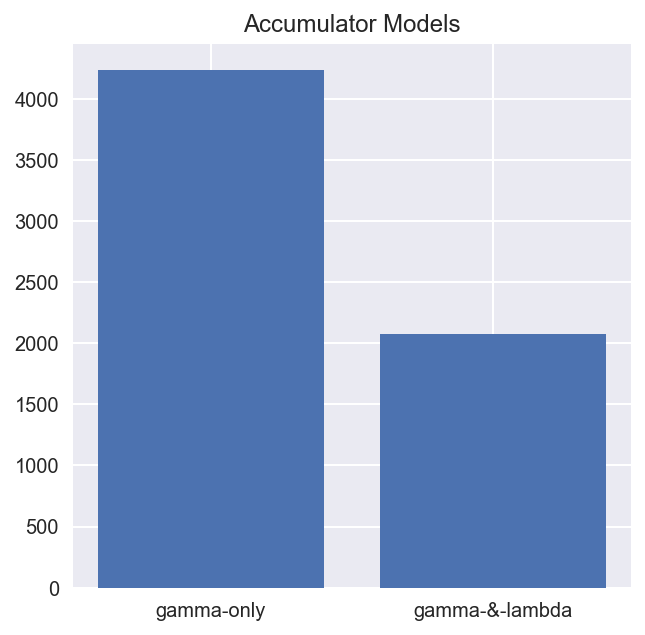

In [135]:
BICs = [best_accumula1_BIC,best_accumula2_BIC]
plt.bar(range(len(BICs)),BICs, align='center')
plt.xticks(range(len(BICs)), ['gamma-only','gamma-&-lambda'])
plt.title("Accumulator Models")

In [90]:
parameters_model2 = pd.DataFrame({'gamma':gamma_all,'lambda':lambda_all})
parameters_model2

,gamma,lambda
0,1.0,1.3
1,1.0,1.3
2,1.0,1.3
3,1.0,1.3


In [92]:
# Using z-matrix (results of gamma+lambda free paramters model)
aggregate_trial_3 = np.column_stack((data_accumula,z_matrix_acc2))
data_accumula3 = pd.DataFrame(aggregate_trial_3,columns=["subject","trial","rt","choice","gaze_0","gaze_1","item_value_0","item_value_1","correct","fix_seq","gamma","lambda","DEv","xL","xR"])

In [93]:
#drop columns with many datapoints
data_all = data_all.drop(['Unnamed: 0'], axis=1)
data_all.head()

,Part,TrialN,PairID,LItem,LVal,RItem,RVal,Choice,RT,Conf,...,zRVal,zLFam,zRFam,zLValConfBDM,zLFamConfBDM,zRValConfBDM,zRFamConfBDM,ConfSplit,GSFSplit,DDTSplit
0,1,41,57,40_nestle_rolo.png,1.10,48_mentos_mint.png,0.95,0,2009,80,...,-1.237881,0.203270,-0.149629,-0.539889,-1.255416,-0.122804,-0.535705,1,0,0
1,1,42,41,11_lindt_orange.png,2.00,59_crunchie.png,1.70,0,3371,78,...,0.457846,0.676154,0.852603,0.294282,0.903717,-0.122804,0.903717,1,1,0
2,1,43,11,18_galaxy_bar.png,1.10,32_snickers.png,2.30,1,1700,82,...,1.814428,0.676154,0.852603,0.294282,1.383045,0.711367,0.184006,1,0,1
3,1,44,60,57_food_doctor_mild_korma_crisps.png,1.25,110_bombay_mix.png,1.40,1,7466,42,...,-0.220445,-2.619919,-0.149629,-1.374061,-0.535705,-0.956975,-1.975128,0,1,0
4,1,45,5,113_walkers_cheese.png,2.00,32_snickers.png,2.30,1,1889,70,...,1.814428,0.379719,0.852603,0.711367,-0.535705,0.711367,0.184006,0,0,1


In [94]:
data5 = pd.concat([data_all, data_accumula3],axis=1)
data5["AbsDEv"] = abs(data5["DEv"])

In [95]:
# To avoid problem of inexplicable transposition of the columns
data5.to_csv('data/FF2018_data/Aggregate_Acc_Data_All_Like_optim.csv',index = False)
data5 = pd.read_csv('data/FF2018_data/Aggregate_Acc_Data_All_Like_optim.csv')


In [96]:
zDx_last=[]
zAbs_Dx_last=[]

for i in (data5['Part'].unique()):
    Choicedata = data5.loc[data5['Part'] == i]    
    
    pX_Dx_last = pd.to_numeric(Choicedata["DEv"].values) 
    pX_zDx_last = (pX_Dx_last - np.mean(pX_Dx_last))/np.std(pX_Dx_last)

    pX_Abs_Dx_last = pd.to_numeric(Choicedata["AbsDEv"].values) 
    pX_zAbs_Dx_last = (pX_Abs_Dx_last - np.mean(pX_Abs_Dx_last))/np.std(pX_Abs_Dx_last)
    
    #z_matrix_aux= np.column_stack((pX_zRT,pX_zDAbsEvi,pX_zDR,pX_zDV,pX_zDG))
    
    for  j in range(len(pX_zAbs_Dx_last)):    
        zDx_last.append(pX_zDx_last[j])
        zAbs_Dx_last.append(pX_zAbs_Dx_last[j])

data5['zDEv']=zDx_last
data5['zAbsDEv']=zAbs_Dx_last

In [97]:
data5.head()

,Part,TrialN,PairID,LItem,LVal,RItem,RVal,Choice,RT,Conf,...,correct,fix_seq,gamma,lambda,DEv,xL,xR,AbsDEv,zDEv,zAbsDEv
0,1,41,57,40_nestle_rolo.png,1.10,48_mentos_mint.png,0.95,0,2009,80,...,1.0,[1 1 2 2 2 1],1.0,1.3,-0.15,"[0, 1.1, 2.5300000000000002, 2.530000000000000...","[0, 0.95, 2.38, 2.38, 2.38, 2.38, 4.2390000000...",0.15,-0.242061,-0.988498
1,1,42,41,11_lindt_orange.png,2.00,59_crunchie.png,1.70,0,3371,78,...,1.0,[1 1 1 2 2 1 1 1 1 1],1.0,1.3,-0.30,"[0, 2.0, 4.6, 7.9799999999999995, 7.9799999999...","[0, 1.7, 4.3, 7.68, 7.68, 7.68, 12.074, 17.786...",0.30,-0.484123,-0.570823
2,1,43,11,18_galaxy_bar.png,1.10,32_snickers.png,2.30,1,1700,82,...,1.0,[1 1 1 2 2],1.0,1.3,1.20,"[0, 1.1, 2.5300000000000002, 4.389000000000001...","[0, 2.3, 3.73, 5.589, 5.589, 5.589]",1.20,1.936492,1.935228
3,1,44,60,57_food_doctor_mild_korma_crisps.png,1.25,110_bombay_mix.png,1.40,1,7466,42,...,1.0,[1 1 2 2 2 1 1 1 1 2 2 1 1 1 1 1 1 1 2 2 2 2],1.0,1.3,0.15,"[0, 1.25, 2.875, 2.875, 2.875, 2.875, 4.987500...","[0, 1.4, 3.025, 3.025, 3.025, 3.025, 5.1375, 7...",0.15,0.242061,-0.988498
4,1,45,5,113_walkers_cheese.png,2.00,32_snickers.png,2.30,1,1889,70,...,1.0,[1 1 1 1 2 2],1.0,1.3,0.30,"[0, 2.0, 4.6, 7.9799999999999995, 12.374, 12.3...","[0, 2.3, 4.9, 8.28, 12.674, 12.674, 12.674]",0.30,0.484123,-0.570823


## Using  accumulator results we fit choice ($\Delta$Accumulators) and confidence (|$\Delta$Accumulators|)

In [98]:
%%R -i data5
d <- data5

BIC: 5489.359
Call:  glm(formula = Choice ~ zDEv, family = binomial(link = "logit"), 
    data = d)

Coefficients:
(Intercept)         zDEv  
   0.004058     0.131126  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    5490 
Residual Deviance: 5473 	AIC: 5477


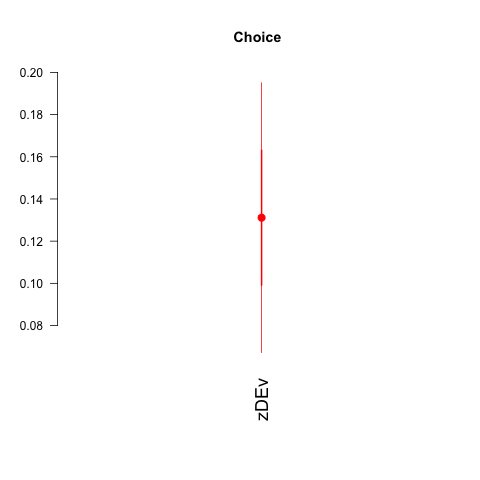

In [99]:
%%R    
title_plot = "Choice  "
ModelChoice_1 <- glm(Choice ~ zDEv  , data= d,family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

BIC: 10860.84
Call:  glm(formula = zConf ~ zAbsDEv, data = d)

Coefficients:
(Intercept)      zAbsDEv  
    0.09837      0.05287  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    3589 
Residual Deviance: 3578 	AIC: 10840


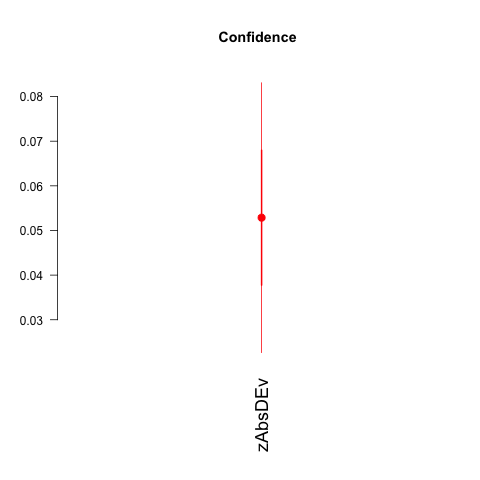

In [100]:
%%R    
title_plot = "Confidence  "
ModelConf_1 <- glm(zConf ~ zAbsDEv  , data= d)
coefplot(ModelConf_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1conf = BIC(ModelConf_1)
cat("BIC:" , BIC1conf)
ModelConf_1

BIC: 10724.55
Call:  glm(formula = zConf ~ zAbsDVal, data = d)

Coefficients:
(Intercept)     zAbsDVal  
    0.09867      0.18289  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    3589 
Residual Deviance: 3457 	AIC: 10710


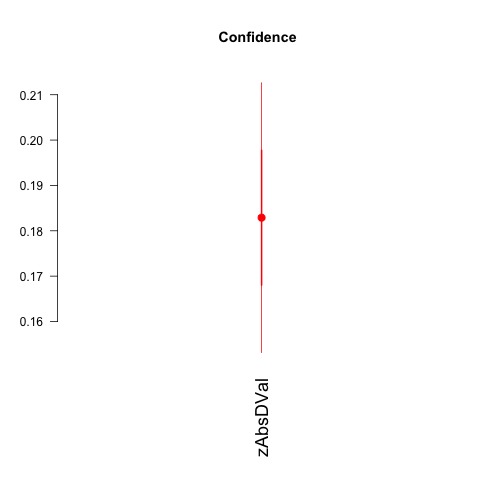

In [101]:
%%R    
title_plot = "Confidence  "
ModelConf_1 <- glm(zConf ~ zAbsDVal  , data= d)
coefplot(ModelConf_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1conf = BIC(ModelConf_1)
cat("BIC:" , BIC1conf)
ModelConf_1

## --- [END]

In [9]:
# in this case we have 2 degrees of freedom (slope logistic regression and gamma)        
  
aggregate_trial = np.column_stack((data,z_matrix))

data1.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,abs_evid_1,R0_star,R1_star,R0,R1,R0_glam,R1_glam
0,0.0,0.0,2009.0,0.0,0.0,0.0,0.568396,0.431604,-0.45,0.000000,0.000000,0.000000,0.000000,0.420407,0.579593,0.500000,0.500000
1,0.0,1.0,3371.0,0.0,5.0,4.0,0.762332,0.237668,-0.45,3.276906,-0.421525,3.698430,-3.698430,1.000000,0.000000,0.778590,0.221410
2,0.0,2.0,1700.0,1.0,0.0,5.0,0.446809,0.553191,-0.45,0.000000,1.760638,-1.760638,1.760638,0.144491,0.855509,0.354660,0.645340
3,0.0,3.0,7466.0,1.0,1.0,2.0,0.532352,0.467648,-0.45,0.321911,0.456179,-0.134268,0.134268,0.399365,0.600635,0.488589,0.511411
4,0.0,4.0,1889.0,1.0,5.0,5.0,0.529736,0.470264,-0.45,1.590589,1.159411,0.431177,-0.431177,0.487978,0.512022,0.536585,0.463415


## Notation used for evidence terms used in GLAM

DA = DAbsEvi = data1.abs_evid_1 - data1.abs_evid_0  with Ai equation in Thomas et al. (2017)

Considering Rstar_i = Ai - A(no_i) 

Ri = F1(Rstar_i) and transformation F1 given by (Ri_star-Ri_star.min())/(Ri_star.max()-Ri_star.min())

Ri_glam = F2(Rstar_i) and transformation F2 given by 1/(1+exp(-Ri_star*0.34))

DR = R1 -R0

DR_glam = R1_glam -R0_glam

             

In [11]:
data1["DAbsEvi"] = DAbsEvi
data1["DR"] = DR
data1["DR_glam"] = DR_glam
data1["DV"] = DVal
data1["AbsDV"] = DVal.abs()
data1["DGaze"] = DGaze
data1["correct"] = correct

In [12]:
data1.loc[data['subject'] == 3].head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,R1,R0_glam,R1_glam,DAbsEvi,DR,DR_glam,DV,AbsDV,DGaze,correct
360,3.0,0.0,3916.0,0.0,0.0,0.0,0.686415,0.313585,-0.59,0.000000,...,0.506396,0.500000,0.500000,0.000000,0.012791,0.000000,0.0,0.0,-0.372829,1
361,3.0,1.0,2427.0,0.0,5.0,2.0,0.726171,0.273829,-0.59,2.823058,...,0.129716,0.743640,0.256360,-3.132281,-0.740568,-0.487280,-3.0,3.0,-0.452342,0
362,3.0,2.0,3746.0,1.0,1.0,1.0,0.421530,0.578470,-0.59,0.080232,...,0.536404,0.478802,0.521198,0.249535,0.072808,0.042396,0.0,0.0,0.156941,1
363,3.0,3.0,3621.0,0.0,3.0,1.0,0.919054,0.080946,-0.59,2.613885,...,0.136583,0.739922,0.260078,-3.075181,-0.726835,-0.479843,-2.0,2.0,-0.838107,0
364,3.0,4.0,2167.0,1.0,4.0,3.0,0.293122,0.706878,-0.59,-0.495746,...,0.758642,0.328899,0.671101,2.097556,0.517284,0.342202,-1.0,1.0,0.413757,0
